# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [7]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [8]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()            
        )

    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [9]:
from common_utils import split_dataset, preprocess_dataset
import pandas as pd

def preprocess(df):
    
    X_train, y_train, X_test, y_test = split_dataset(df,['filename','label'],0.3,1)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [10]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X =torch.tensor(X, dtype=torch.float)
    self.y =torch.tensor(y, dtype=torch.float).unsqueeze(1)
    
  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return self.X[idx], self.y[idx]


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    train_data = CustomDataset(X_train_scaled, y_train)
    test_data = CustomDataset(X_test_scaled, y_test)

    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)

    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [11]:
# YOUR CODE HERE
model = MLP(77, 128, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [12]:
from common_utils import EarlyStopper

epochs = 100
early_stopper = EarlyStopper(patience=3, min_delta=0)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += ((pred > 0.5).type(torch.float) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    print(f"Train Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5).type(torch.float) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct

train_loss, test_loss = [], []
train_acc, test_acc = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_loss, acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(tr_loss), train_acc.append(acc)
    
    te_loss, acc = test_loop(test_dataloader, model, loss_fn)
    test_loss.append(te_loss), test_acc.append(acc)

    if early_stopper.early_stop(te_loss): 
        print("Done!")
        break


Epoch 1
-------------------------------
loss: 0.696389  [  256/ 8439]
Train Error: 
 Accuracy: 54.2%, Avg loss: 0.687311 

Test Error: 
 Accuracy: 56.6%, Avg loss: 0.684143 

Epoch 2
-------------------------------
loss: 0.686217  [  256/ 8439]
Train Error: 
 Accuracy: 58.9%, Avg loss: 0.670955 

Test Error: 
 Accuracy: 58.4%, Avg loss: 0.675280 

Epoch 3
-------------------------------
loss: 0.646943  [  256/ 8439]
Train Error: 
 Accuracy: 60.6%, Avg loss: 0.657552 

Test Error: 
 Accuracy: 58.6%, Avg loss: 0.667659 

Epoch 4
-------------------------------
loss: 0.643440  [  256/ 8439]
Train Error: 
 Accuracy: 62.3%, Avg loss: 0.643821 

Test Error: 
 Accuracy: 61.3%, Avg loss: 0.654700 

Epoch 5
-------------------------------
loss: 0.605831  [  256/ 8439]
Train Error: 
 Accuracy: 64.0%, Avg loss: 0.633288 

Test Error: 
 Accuracy: 62.4%, Avg loss: 0.647046 

Epoch 6
-------------------------------
loss: 0.606368  [  256/ 8439]
Train Error: 
 Accuracy: 65.8%, Avg loss: 0.614672 

Te

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


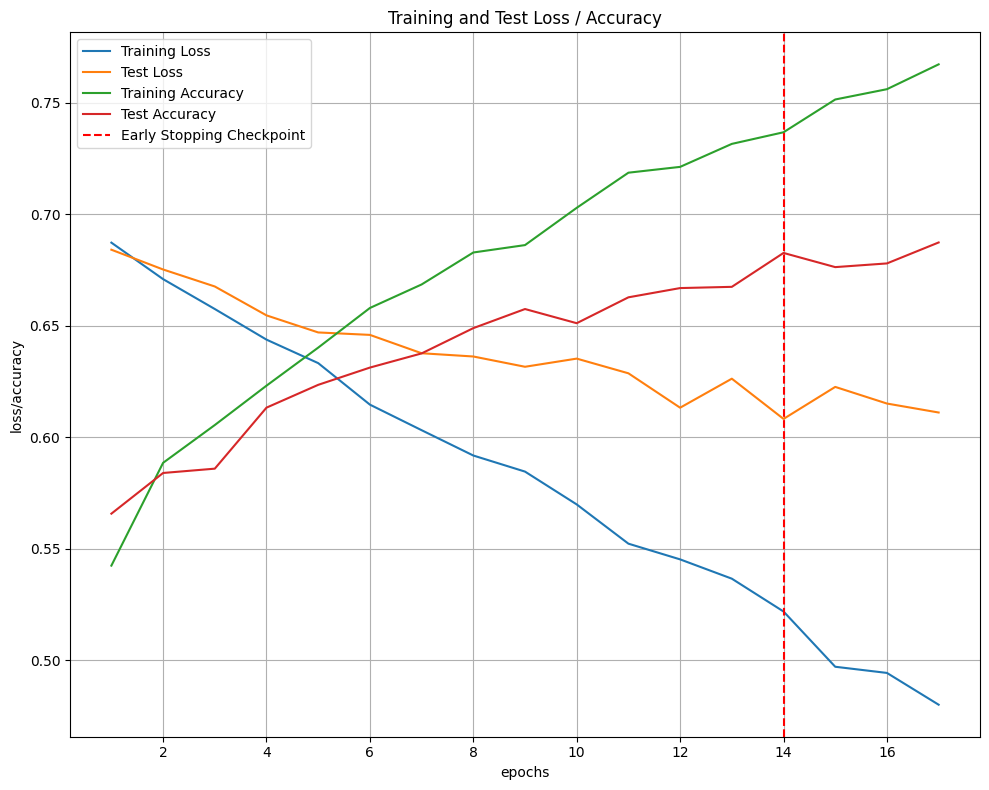

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(test_loss)+1),test_loss,label='Test Loss')

plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')
plt.plot(range(1,len(test_acc)+1),test_acc,label='Test Accuracy')

# find position of lowest validation loss
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.title('Training and Test Loss / Accuracy')
plt.xlabel('epochs')
plt.ylabel('loss/accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# plt.figure(figsize=(12,8))
# plt.plot(train_loss, label='Train Loss')    
# plt.plot(test_loss, label='Test Loss')
# plt.plot(train_acc, label='Train Accuracy')
# plt.plot(test_acc, label='Test Accuracy')

# plt.title('Training and Test Loss / Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Loss / Accuracy')

# plt.legend()
# plt.show()

2. Comment on line plots.

In [14]:
# YOUR CODE HERE
answer = ""